# Root finding

## Objectives

The root finding algorithm was developed with the following objectives:

- **Simplicity**: No parameters need to be chosen for it to work. The only inputs are the definition of the function, the desired range, and optionally the accuracy of the computed roots.
- **Accuracy**: The algorithm works to near-machine precision. We guarantee that no falsely duplicate roots are returned.
- **Speed**: The solution should be available (nearly) _instantaneously_. For large function domains/search spaces, the algorithm is parallelisable. The user need only split the whole search space (it is recommended that $F(x_s) \gg 1$ at the splits $x_s$) and process it in part.
- **Generality**: The algorithm can be applied to find the roots of $F(x) = 0$.

## Caveats

There are a few caveats:

- We cannot guarantee that the algorithm finds _all_ roots. However, by having a recursive component, it is fair to assume that for a well-behaved function the algorithm finds all roots that are numerically unique (to machine precision).
- While we guarantee that no duplicate roots are returned, this algorithm makes no guaratees to find actual double roots (such as $x^2 = 0$, where we may or may not find $x = 0$).

In [1]:
# initial imports and definitions

import sys
sys.setrecursionlimit(1000)  # for root finder

import time

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from chebpy import chebfun

from diffusion import Domain
from diffusion.analytical import Solver

def cheblen(cheb):
    """Length of chebfun with no breakpoints."""
    return cheb.funs[0].size


## A simple domain

We will consider, for the purpose of illustrating the method, a simple domain with three compartments. This has the added benefit of a relatively simple function.

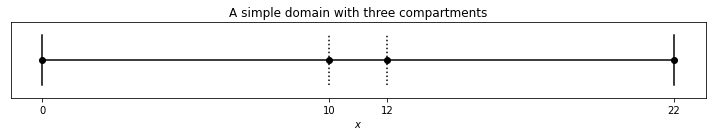

In [2]:
# define the domain as three compartments
domain = Domain([10, 2, 10], [1, 1, 1], [0, 0.01, 0.01, 0])
solver = Solver(domain)
xb = domain.barriers  # aux variable for barrier position

# plot domain, nothing fancy
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.set_title('A simple domain with three compartments')
ax.plot((xb[[0,-1]], xb[[0,-1]]), (-1, +1), 'k-')  # domain ends
ax.plot((xb[1:-1], xb[1:-1]), (-1, +1), 'k:')  # internal barriers
ax.plot(xb, 0*xb, 'ko-')  # compartments
ax.set_xlabel('$x$')
ax.set_xticks(xb)
ax.set_yticks([])
ax.set_ylim((-1.5, +1.5))

# show the figure
fig.tight_layout()
plt.show()

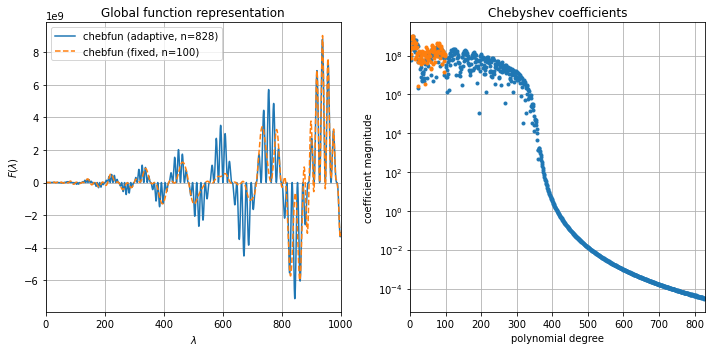

In [3]:
# construct global chebfun
zero = 0  # (>= 0) from where to start finding roots
max_lambda = 1000  # maximum lambda value
cheb_fixed = chebfun(solver.eval_F, (zero, max_lambda), n=100)
cheb_adapt = chebfun(solver.eval_F, (zero, max_lambda))

# create the figure
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# plot the function
x_cheb = np.linspace(zero, max_lambda, 10001)
ax = axes[0]
ax.set_title('Global function representation')
ax.plot(x_cheb, cheb_adapt(x_cheb), ls='-',
        label='chebfun (adaptive, n={})'.format(cheblen(cheb_adapt)))
ax.plot(x_cheb, cheb_fixed(x_cheb), ls='--',
        label='chebfun (fixed, n={})'.format(cheblen(cheb_fixed)))
ax.set_xlabel('$\\lambda$')
ax.set_ylabel('$F(\\lambda)$')
ax.set_xlim((0, max_lambda))
ax.legend()
ax.grid()

# plot the coefficients
ax = axes[1]
ax.set_title('Chebyshev coefficients')
cheb_adapt.plotcoeffs(ax=ax)
cheb_fixed.plotcoeffs(ax=ax)
ax.set_xlim([0, max(cheblen(cheb_adapt), cheblen(cheb_fixed))])
ax.grid()

# show the figure
fig.tight_layout()
plt.show()

## Finding the roots

As we could see, the function is highly oscillatory with many roots. We can use our rootfinding algorithm to find all values of $\lambda_0$.

In [4]:
# find roots
tic = time.time()
params = dict(root_accuracy=dict(maxiter=10, warn=False))  # accuracy
x_0, y_0 = solver.find_eigV(max_lambda, zero=zero, return_error=True, **params)
toc = time.time() - tic

# show results
print('Root finding took {:g} seconds.'.format(toc)
     +' We found {:d} roots'.format(x_0.size)
     +' in the interval [{0:g},{1:g}]'.format(zero, max_lambda))
print('The first 10 roots are:\n', x_0[:10])

# also show the global chebfun roots
roots_cheb = cheb_adapt.roots()  # instantaneous, no need to time
print('\nBy comparison, the first 10 (of {:d}) roots'.format(len(roots_cheb))
     +' of the global chebfun fit are:\n', roots_cheb[:10])

Root finding took 5.1255 seconds. We found 223 roots in the interval [0,1000]
The first 10 roots are:
 [0.00000000e+00 9.58266131e-04 1.05751456e-02 1.00539491e-01
 1.00896900e-01 3.96492051e-01 4.01279013e-01 8.89875184e-01
 8.94356885e-01 1.57771823e+00]

By comparison, the first 10 (of 219) roots of the global chebfun fit are:
 [6.30806548e-04 2.53022220e-03 1.07435080e-02 1.00547934e-01
 1.01018598e-01 8.90205100e-01 8.90307944e-01 1.58109936e+00
 1.58113000e+00 2.46740932e+00]


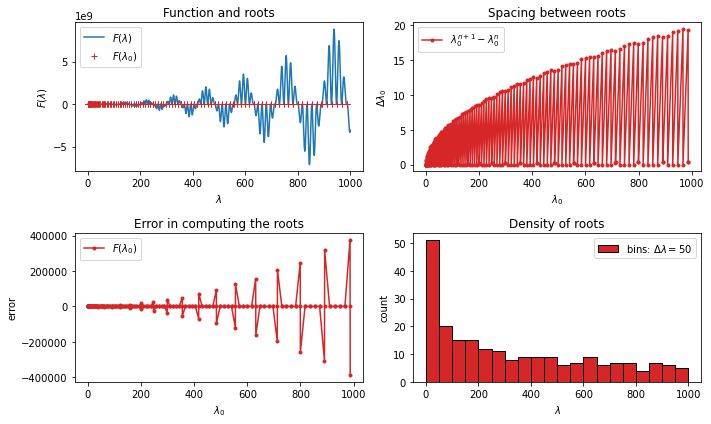

In [5]:
# create the figure to illustrate roots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

x_F = np.linspace(zero, max_lambda, 10001)
y_F = solver.eval_F(x_F)
ax = axes[0, 0]  # top left
ax.set_title('Function and roots')
ax.plot(x_F, y_F, '-', color='tab:blue', label='$F(\\lambda)$')
ax.plot(x_0, y_0, '+', color='tab:red', label='$F(\\lambda_0)$')
ax.set_xlabel('$\\lambda$')
ax.set_ylabel('$F(\\lambda)$')
ax.legend()

ax = axes[1, 0]  # bottom left
ax.set_title('Error in computing the roots')
ax.plot(x_0, y_0, '.-', color='tab:red', label='$F(\\lambda_0)$')
ax.set_xlabel('$\\lambda_0$')
ax.set_ylabel('error')
ax.legend()

diff = np.concatenate(([0], np.diff(x_0)))
ax = axes[0, 1]  # top right
ax.set_title('Spacing between roots')
ax.plot(x_0, diff, '.-', color='tab:red',
        label='$\\lambda_0^{{n+1}} - \\lambda_0^n$')
ax.set_xlabel('$\\lambda_0$')
ax.set_ylabel('$\\Delta\\lambda_0$')
ax.legend()

bins = np.linspace(zero, max_lambda, 21)  #TODO: logspace?
ax = axes[1, 1]  # bottom right
ax.set_title('Density of roots')
ax.hist(x_0, bins=bins, color='tab:red', edgecolor='k',
        label='bins: $\\Delta\\lambda = {:.0f}$'.format(bins[1]-bins[0]))
ax.set_xlabel('$\\lambda$')
ax.set_ylabel('count')
ax.legend()

# show the figure
fig.tight_layout()
plt.show()

## Difficult roots

Here, we show three sets of difficult roots. They occur very close to a local extremum, which barely crosses the $x$-axis. These locations are chosen arbitrarily, but we make sure it includes a set of roots of $\lambda \ll 1$ and one with $\lambda \gg 1$.

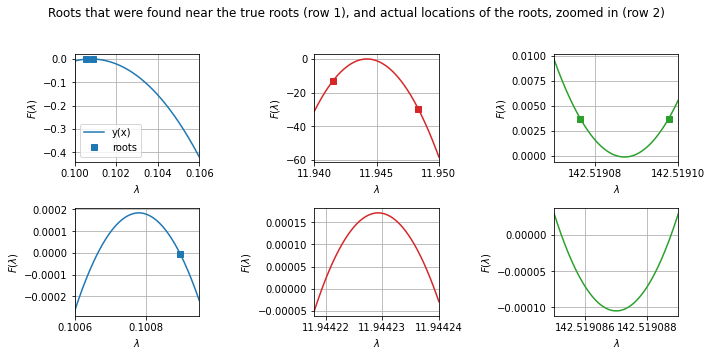

In [6]:
# selected intervals for plotting
lims = [[(0.10000, 0.10600), (11.940000, 11.950000), (142.519070, 142.519100)],
        [(0.10060, 0.10095), (11.944218, 11.944240), (142.519085, 142.519089)]]
nROIs = len(lims[0])
colors = ['tab:blue', 'tab:red', 'tab:green']

# create figure
fig, axes = plt.subplots(2, nROIs, figsize=(10, 5))

# plotting
for rowaxes, rowlims in zip(axes, lims):
    for ax, color, (xmin, xmax) in zip(rowaxes, colors, rowlims):
        x_F_zoomed = np.linspace(xmin, xmax, 1001)
        y_F_zoomed = solver.eval_F(x_F_zoomed)
        subset_roots = np.logical_and(x_0>=xmin, x_0<=xmax)
        x_0_zoomed = x_0[subset_roots]
        y_0_zoomed = y_0[subset_roots]
        ax.plot(x_F_zoomed, y_F_zoomed, '-', color=color, label='y(x)')
        ax.plot(x_0_zoomed, y_0_zoomed, 's', color=color, label='roots')
        ax.set_xlabel('$\\lambda$')
        ax.set_ylabel('$F(\\lambda)$')
        ax.set_xlim((xmin, xmax))  # clip
        ax.locator_params(axis='x', nbins=3)  # not too many ticks
        ax.ticklabel_format(useOffset=False, style='scientific')
        ax.grid()

# prettify
fig.suptitle('Roots that were found near the true roots (row 1),'
            +' and actual locations of the roots, zoomed in (row 2)')
axes[0, 0].legend()

# show the figure
fig.tight_layout(rect=[0, 0, 1, 0.95])  # protect suptitle
plt.show()

## Verify eigenmodes

For each eigenvalue, we compute the eigenmodes over a discretized domain. For the n-th eigenmode, there should be n sign changes. This allows us to verify that the eigenvalues were correctly identified and none are missing. However, it does not provide information about the accuracy of the eigenvalues. As long as the eigenvalue is within some range of the true eigenvalue, the computed eigenmode will produce the same number of sign changes.

It can happen that two eigenvalues are so close that numerically they produce the same eigenmodes and/or number of sign changes. This also depends on the choice of domain discretization.

In [7]:
# compute eigenmodes and sign changes
xq = np.linspace(0, domain.total_length, 10001)
eigM = solver.find_eigM(xq)
nSignChanges, nthMode = solver.verify_eigM()

# print as a table
out = np.column_stack((np.array(nthMode, dtype=int), nSignChanges, x_0))
np.set_printoptions(linewidth=160)  # make wide enough
print('nMode | nSign | eigV')
print('------+-------+-----')
for i, out_i in enumerate(out[:10, :]):  # slice to limit screen output
    print('{:^5.0f} | {:^5.0f} | {:<g}'.format(*out_i))
print('{:^6s}|{:^7s}| :\n'.format(':', ':'))

# verify everything
match = out[:, 0] == out[:, 1]
if np.all(match):
    print('All {:d} eigenmodes'.format(len(match))
         +' have a matching number of sign changes in the domain.')
else:
    first = np.where(np.invert(match))[0][0]
    print('The first eigenmode with incorrect sign changes is'
         +' at n={:d} with eigV={:g}'.format(first, solver.eigV[first]))

nMode | nSign | eigV
------+-------+-----
  0   |   0   | 0
  1   |   1   | 0.000958266
  2   |   2   | 0.0105751
  3   |   3   | 0.100539
  4   |   4   | 0.100897
  5   |   5   | 0.396492
  6   |   6   | 0.401279
  7   |   7   | 0.889875
  8   |   8   | 0.894357
  9   |   9   | 1.57772
  :   |   :   | :

All 223 eigenmodes have a matching number of sign changes in the domain.
